<center><h1> Gaussian Mixture Model

Tarea 4

por: **José Miguel Muñoz Arias**



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Desarrollé el clusterizador de Gaussian Mixture Model optimizado con Maximum Expectation para el Log likelihood utilizando una aproximación orientada a objetos. 

Por consiguiente, la clase GMM tiene los parámetros necesarios para clusterizar los datos de un espacio arbtrario $\mathbb{R}^n$ (con datos con $n$ atributos) y separarlo en $k$ clusters con distribuciones normales. A continuación está el código comentando cada función con docstrings:

In [2]:
class GMM: #Gaussian Mixture Model

  def __init__(self ,datosX, k,estimador="LogLike",funcion="Gaussian"):
    """
    pasar los datosX como pandas
    """
    ################ Hiper Parámetros ###############
    self.k=k #Número de clusters a utilizar
    self.datosX=datosX.copy() #datos para clustrizar
    self.datosX["ClusterActual"]=np.random.randint(0, self.k, self.datosX.shape[0])
    self.estimador=estimador #función para hacer el Maximum-expectation: SOLO HE IMPLEMENTADO Log-likelihood
    self.funcion=funcion #Función a la que se parecen los datos
    self.N=len(np.array(datosX.columns)) #Espacio en el que vive cada observación
    ################ Para el modelo necesito: ###############
    self.lDatos=[pd.DataFrame(self.split_datos()[j]) for j in range(k)] #Parto el dataset en el # de clusters
    #Generación de los vectores por clusters con la primera partición de los datos
    self.matsCov=np.array([list(self.matrizCov(j)) for j in range(k)]) #Matrices de covarianza
    self.mu=np.array([list(self.media(j)) for j in range(k)]) #Vector con las medias de cada partición
    self.pesos=[1/self.k]*self.k #Los pesos de cada cluster

  def log_likelihood(self): 
    """
    Retorna el valor de la función Log-Lielihood
    """
    return np.sum([np.log(np.add(np.array(self.p_Pertenencia(xi[:-1])),np.ones(np.array(self.p_Pertenencia(xi[:-1])).shape))) for xi in np.array(self.datosX)])
    


  def Funcion(self,X,j):
    """
    Retornar la función de pertenencia en un vector por variable, en el cluster j
    """
    if self.funcion=="Gaussian" or self.funcion=="g": #ALternativa por si el usuario es perezoso 
      ans=[];i=0
      d=(1/(2*np.pi))**(self.N/2)
      covInv=np.linalg.inv(self.matsCov[j]) #Invierte la matriz de covarianza
      mu=self.media(j) #Calcula la media en el cluster j
      ans=(d*(1/np.linalg.det(self.matsCov[j]))**0.5 * np.exp(-0.5*((np.array(X)-mu)).dot(covInv).dot(np.array(X)-mu).T)) #Densidad gausiana
      return ans


  def matrizCov(self,j):
    """
    Retorna una matriz de covarianza para el cluster j
    """
    return np.array(self.lDatos[j].cov()) 

  def media(self,j):
    """
    La idea es que retorne un vector con la media de todos los datos en cada posición para el cluster j
    """
    mu=np.array([])
    for i in range(self.N):
      mu=np.append(mu,np.mean(np.array(self.lDatos[j][self.datosX.columns[i]])))
    return mu


  def split_datos(self):
    """
    Parte el dataset por partes con el número de clusters
    """
    return np.array_split(self.datosX,self.k)

  def Z(self,x):
    """
    Retorna la suma ponderada del peso por el valor de la normal
    """
    vec=np.array([self.pesos[j]*self.Funcion(x,j) for j in range(self.k)]) #Itero sobre el número de clusters
    return np.sum(vec) #La suma ponderada

  def p_Pertenencia(self,x):
    """
    Retorna una lista con la probabilidad de un dato esté en cada uno de los clusters
    """
    x=np.array(x).flatten()
    z=self.Z(x)
    vect_prob= [ self.pesos[i]*self.Funcion(x,i)/z for i in range(self.k) ]
    return vect_prob

  def maximum_expectation(self,nIter=1000):
    """
    Itera para encontrar el Maximum Expectation Value, a.k.a, maximizar el log-likelihood
    """
    ###### Proceso de aprendizaje #######
    print("Entrenando...")
    for rep in range(nIter):
      self.lDatos=[(self.datosX[self.datosX["ClusterActual"]==i]).copy().drop(["ClusterActual"],axis=1) for i in range(self.k)]
      self.matsCov=np.array([list(self.matrizCov(j)) for j in range(self.k) if len(self.lDatos[j])!=0]) #Matrices de covarianza
      self.mu=np.array([list(self.media(j)) for j in range(self.k) if len(self.lDatos[j])!=0]) #Vector con las medias de cada partición
      def nuevoCluster(x): return np.argmax(self.p_Pertenencia(np.array(x)[:-1]))
      self.datosX["ClusterActual"]=self.datosX.apply(nuevoCluster,axis=1)
      self.pesos=[len(np.array(self.lDatos[i])[0]) for i in range(self.k)]
      if rep%20==0:print("Iteracion {}".format(rep));print("Log-Likelihood actual es: {}".format(self.log_likelihood()))
      if rep==nIter-1:        return self.datosX

# Aplicación a datos arbitrarios:

In [5]:
np.random.seed(10)
a=np.concatenate((np.random.uniform(-3,10,75),np.random.uniform(-6,2,75)));b=np.concatenate((np.random.uniform(-30,11,75),np.random.uniform(15,20,75)))
dataX=pd.DataFrame({"a":a,"b":b})
test=GMM(dataX,5) #Clasifica en 5 clusters
procesados=test.maximum_expectation(100) #Itera 100 veces el maximum expectation

Entrenando...
Iteracion 0
Log-Likelihood actual es: 135.11640397650922
Iteracion 20
Log-Likelihood actual es: 107.3611542756315
Iteracion 40
Log-Likelihood actual es: 107.3611542756315
Iteracion 60
Log-Likelihood actual es: 107.3611542756315
Iteracion 80
Log-Likelihood actual es: 107.3611542756315


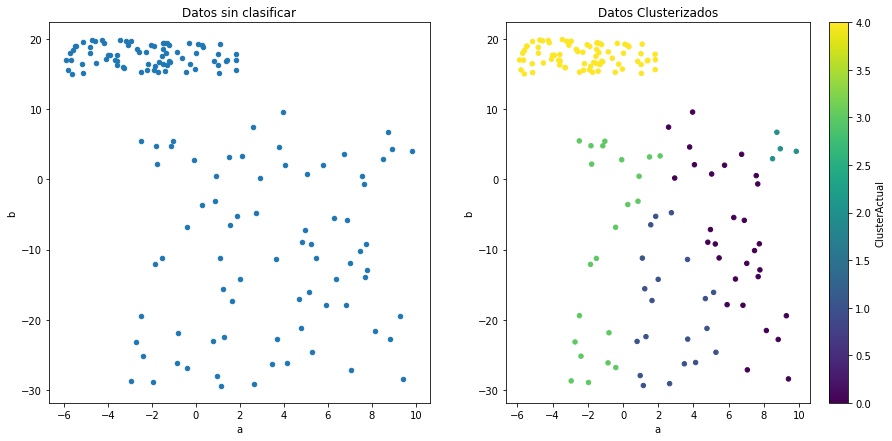

In [6]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
dataX[["a","b"]].plot.scatter("a","b",ax=ax[0]);procesados.plot.scatter("a","b",c="ClusterActual", colormap='viridis',ax=ax[1])
ax[0].set_title("Datos sin clasificar");ax[1].set_title("Datos Clusterizados"); plt.show()